# Bayesian Linear Regression - Function-Space View

## 1. Sampling from a Multivariate Normal Distribution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


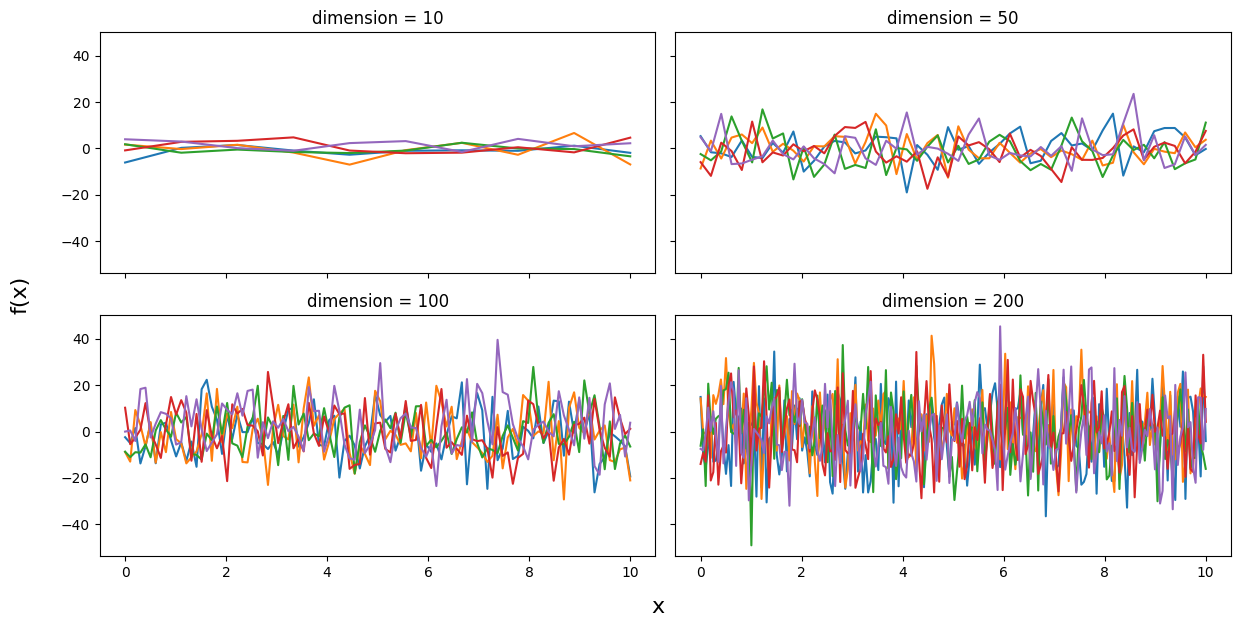

In [2]:
# Set random seed for reproducibility
np.random.seed(24)



# Function to generate a random positive definite matrix (covariance matrix)
def random_cov_matrix(dim):
    """Generate a random symmetric positive definite matrix."""
    A = np.random.randn(dim, dim)
    return np.dot(A, A.T)  # A * A^T ensures it's symmetric and positive definite


# Create figure and axes
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
ax = np.ravel(ax)

# Sample 4 times from multivariate normal for different random covariance matrices
for idx, dim in enumerate((10, 50, 100, 200)):
    
    # Define dimension and test points
    test_points = np.linspace(0, 10, dim)
    
    # generate a random covariance matrix of shape (dim,dim)
    cov = random_cov_matrix(dim)

    
    # Sample from the multivariate normal distribution
    samples = np.random.multivariate_normal(mean=np.zeros_like(test_points), cov=cov, size=5)
    
    # Plot a sample
    ax[idx].plot(test_points, samples.T)  # Transpose so that each row represents a sample
    ax[idx].set_title(f'dimension = {dim}')


# Set x and y axis labels
fig.text(0.51, -0.03, 'x', fontsize=16, ha='center')
fig.text(-0.03, 0.5, 'f(x)', fontsize=16, va='center', rotation='vertical')

plt.tight_layout()
plt.show()

## 2. Covariance Functions and RBF Kernel

In [3]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

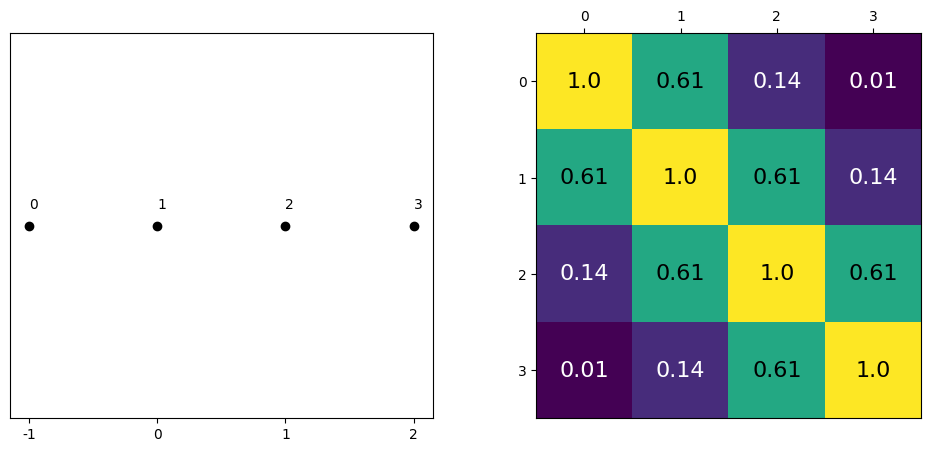

In [4]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

Text(-0.03, 0.5, 'f(x)')

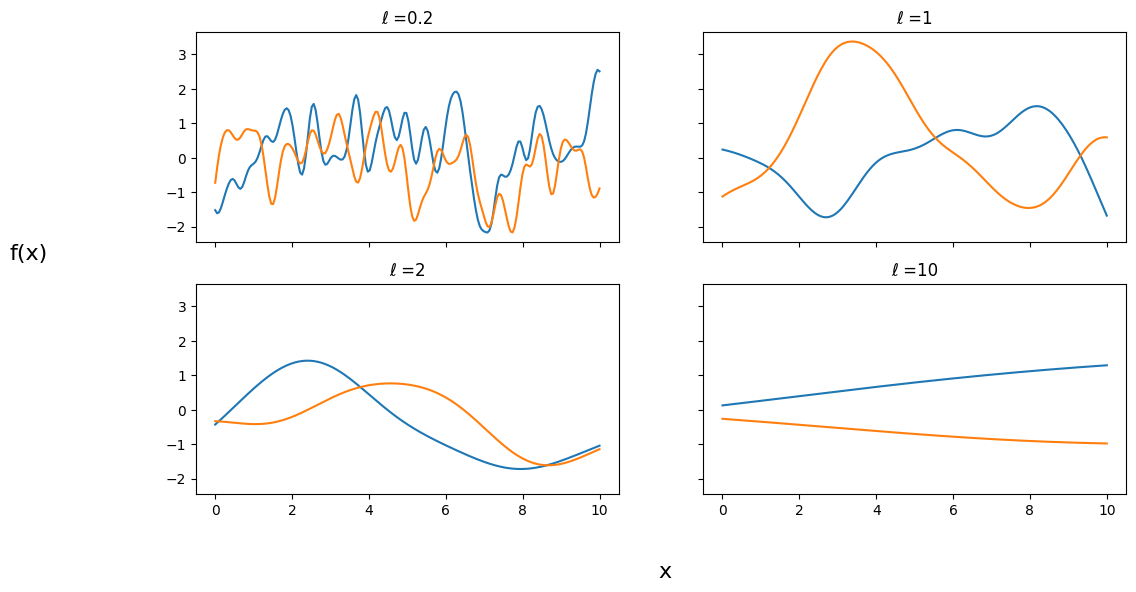

In [5]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, pz.MvNormal(mu=np.zeros_like(test_points), cov=cov).rvs(2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)

## 3. Function-space View

Gaussian processes (GP) define a distribution over functions. A GP is completly specified by its mean function and covariance function. We define the mean function $m(x)$ and the covariance function $k(x,x')$ of $f(x)$ as

$$
\begin{equation}
\begin{split}
\DeclareMathOperator{\E}{\mathbb{E}}
m(x) &= \E[f(x)]\\
k(x,x') &= \E[(f(x)-m(x))(f(x')-m(x'))]
\end{split}
\end{equation}
$$

and will write the Gaussian process as

$$
f(x)\sim \mathcal{GP}\big(m(x),k(x,x')\big)
$$

Usually, we assume the mean function is zero.

In our case the RV represents the function $f(x)$ at location $x$.
For notational convenience we use the enumeration of the cases in the training set to identify the random variables such that $f_i = f(x_i)$ is the RV corresponding to $(x_i,y_i)$.

A GP is defined as a collection of RV. Thus the definition automatically implies a consistency reqequirement, which is also known as the marginalization property. This property simply means that if the GP is specified by $(y_1,y_2) \sim \mathcal{N}\big(\mu,\Sigma\big)$ then $y_1 \sim \mathcal{N}\big(\mu_1,\Sigma_{11}\big)$ holds as well where $\Sigma_{11}$ is a submatrix of $\Sigma$. In other words, examination of a larger set of variables does not change the distribution of the smaller set. I.d. a marginal of a multivariate normal is also Gaussian.

A simple example of a Gaussian Process can be obtained from our Baysian linear regression model $f(x)=\phi(x)^T\mathrm{w}$ with prior $\mathrm{w} \sim \mathcal{N}(0,\Sigma_P)$. We have for the mean and covariance

$$
\begin{equation}
\begin{split}
\DeclareMathOperator{\E}{\mathbb{E}}
\E[f(x)] &= \phi(x)^T\E[\mathrm{w}] = 0 \\
\E[(f(x),(f(x'))] &= \phi(x)^T\Sigma_p\phi(x')\\
\end{split}
\end{equation}
$$

Thus $f(x)$ and $f(x')$ are jointly Gaussian with zero mean and covariance given by $\phi(x)^T\Sigma_P\phi(x')$. 

Let us consider as covariance function the following squared exponential (SE) function:

$$
\text{cov}(f(x_p),f(x_q)) = k(x_P,x_q) = \exp \big(-\frac{1}{2}|x_p-x_q|^2 \big)
$$

In [6]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

For this particular covariance function, we see that the covariance is almost unity between variables whose corresponding inputs are very close, and decreases as their distance in the input space increases.

The specification of the covariance function implies a distribution over functions. To see this, we can draw samples from the distribution of functions evaluated at any number of points; in detail, we choose a number of input points, $X_*$ and write out the corresponding covariance matrix using eq. above elementwise.

Text(0.5, 1.0, 'SE covariance function')

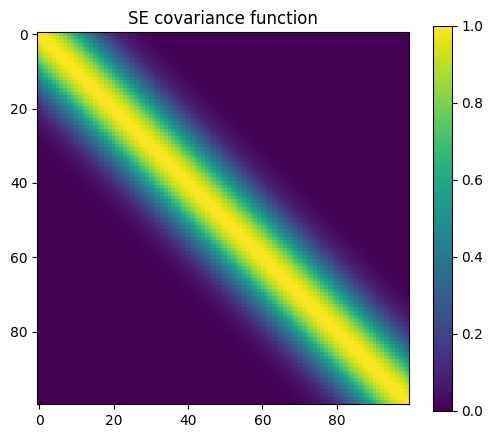

In [7]:
import matplotlib.pyplot as plt
np.random.seed(2)
X_star = np.linspace(-5,5,100)
cov = exp_quad_kernel(X_star,X_star)
fig, ax = plt.subplots(figsize=(6, 5))
h = ax.imshow(cov)
fig.colorbar(h)
plt.title('SE covariance function')

Then we generate a random Gaussian vector by means of this covariance matrix and plot the generated values as a function of the inputs.

$$
f_* \sim \mathcal{N}\big(0,K(X_*,X_*)\big)
$$

In [8]:
X_star = np.linspace(-5,5,100)
cov = exp_quad_kernel(X_star,X_star)
# draw samples from the prior
L = np.linalg.cholesky(cov + 1e-6 * np.eye(100))
np.random.seed(5)
f_prior = np.dot(L, np.random.normal(size=(100,3)))

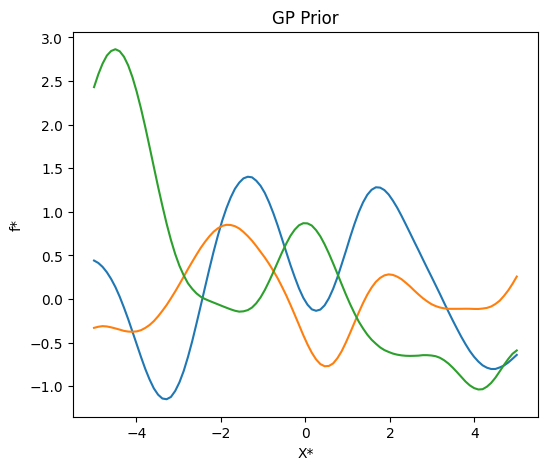

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylabel("f*")
ax.set_xlabel("X*")
plt.title("GP Prior")
ax.plot(X_star,f_prior)

We have shown a probability density that represents *functions*.
The density is known as a process because it is *consistent*. By consistency, here, we mean that the model makes predictions for $\mathbf{f}$ that are unaffected by future values of $\mathbf{f}^*$ that are currently unobserved (such as test points). If we think of $\mathbf{f}^*$ as test points, we can still write down a joint probability density over the training observations, $\mathbf{f}$ and the test observations, $\mathbf{f}^*$. This joint probability density will be Gaussian, with a covariance matrix given by our covariance function.


$$
\begin{bmatrix}\mathbf{f} \\ \mathbf{f}^*\end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top & \mathbf{K}_{\ast,\ast}\end{bmatrix}\right)
$$

where $\mathbf{K}$ is the covariance computed between all the training points, $\mathbf{K}_\ast$ is the covariance matrix computed between the training points and the test points and $\mathbf{K}_{\ast\ast}$ is the covariance matrix computed betwen all the tests points and themselves. For convenience we define

$$
\begin{equation}
\begin{split}
\mathbf{K} &= K(X,X) \\
\mathbf{K}_* &= K(X,X_*) \\
\mathbf{K}_*^T &= K(X_*,X) \\
\mathbf{K}_{**} &= K(X_*,X_*) \\
\end{split}
\end{equation}
$$

$\mathbf{f}$ denotes the vector of latent function values of the training data $[f(x_1),f(x_2),...,f(x_n)]^T$ and therefore $\mathbf{f}_*$ denotes the vector of the test points or the prediction values.

## Predictive

In the same way as in the derevations before we're interested to make predictions with our knowledge of $X$ and $y$. By taking the example of the baysian linear regression we redefine the setting in the function-space view.

$$
y = f(x) + \epsilon 
$$

and

$$
f(x)\sim \mathcal{GP}\big(m(x),k(x,x')\big) \quad
\epsilon \sim \mathcal{N}(0,\sigma_{n}^2\mathrm{I})
$$

There's one important point to emphasize: $y$ can't be observed directly because of the noise. Our assumption by this model is that the real values are generated by the latent function $f(x)$ which we defined to be a Gaussian Process plus some noise.

We derived the predictive distribution for an unseen datapoint $x_*$ in the weight-space view with

$$
\begin{equation}
\begin{split}
f(\mathrm{f}_* \mid x_*, X, \mathrm{y}) 
    &= \int f(\mathrm{f}_* \mid x_{*},\mathbf{w})
        f(\mathrm{w} \mid X, \mathbf{y}) d\mathrm{w} \\ 
\end{split}
\end{equation}
$$

This setting can also be applied in the function-view space by following adaptions

$$
\begin{equation}
\begin{split}
f(\mathbf{f}_* \mid X_*, X, \mathbf{y}) 
    &= \int f(\mathbf{f_*} \mid \mathbf{f},X_*, X)
        f(\mathbf{f} \mid X,\mathbf{y}) d\mathrm{f} \\ 
\end{split}
\end{equation}
$$

where the second distribution is the posterior distribution which states how probable it is to observe $\mathbf{f}$ given $X$ and $\mathbf{y}$. The first distribution states the density for $\mathbf{f_*}$ condtioned on $\mathbf{f},X_*$ and $X$. This distribution is simply a conditonal multivariate normal with the defined kernel function as covariance matrix. Finally we integrate out $\mathbf{f}$ to get the predictive destribution of $\mathbf{f_*}$ which is only depending on our knowledge and a new point $X_*$. Let's derive this calculations in the same way we did it in the views before.

### Posterior

As in the weight-space the posterior in the baysian way is defined by

$$
\text{posterior} = \frac{\text{likelihood x prior}}{\text{marginal likelihood}},\quad
f(\mathbf{f} \mid X,\mathbf{y}) = \frac{f(\mathbf{y} \mid \mathbf{f}, X)
    f(\mathbf{f}\mid X)}{f(\mathrm{y} \mid X)}
$$

The marginal likelihood isn't depending on $\mathbf{f}$ and doesn't need to be considered in the derivations as long we want to show, that the posterior is a unnomralized Normal. For fitting a GP the marginal likelihood will be important and analysed in later sections.

The likelihood expresses how likely it is to observe $y$ given $\mathbf{f}$ and is given by

$$
f(\mathbf{y} \mid \mathbf{f}, X) = 
\frac{1}{\sqrt {2\pi   \sigma_n^2\mathrm{I}} }
    \exp
        \left(
        -\frac{1}{2}
        (\mathbf{f}-\mathbf{y})^T
        \sigma_n^{-2}\mathrm{I}
        (\mathbf{f}-\mathbf{y})\right) 
$$    

and as prior we define a GP with zero mean and any kernel function as covariance function.

$$
f(\mathbf{f}\mid X) = \frac{1}{\sqrt{2\pi^N|\mathbf{K}|}}
    \exp\big(
        -\frac{1}{2}(\mathbf{f}-0)^T\mathbf{K}^{-1}(\mathbf{f}-0)
        \big)
$$

which is simply the GP we have seen before

$$
f(\mathbf{f}\mid X)\sim \mathcal{GP}\big(0,\mathbf{K}\big)
$$

When putting them together we get

### Conditional

The next reasonable step seems to define a distribution of $\mathbf{f}_*$ conditioned on the training data and the observed test point $x_*$.

$$
\begin{equation}
\begin{split}
f(\mathbf{f_*} \mid \mathbf{f}, x_*, X, \mathrm{y}) 
& \propto
    \exp
    \Bigg(
        -\frac{1}{2}
        \Bigg(
            \begin{bmatrix}
                \mathbf{f} \\ \mathbf{f}^*
            \end{bmatrix}
            -
            \begin{bmatrix}
                M(X) \\ M(X_*)
            \end{bmatrix}
        \Bigg)^T
        \begin{bmatrix} 
            \mathbf{K} 
            & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top 
            & \mathbf{K}_{\ast,\ast}
        \end{bmatrix}^{-1}
        \Bigg(
            \begin{bmatrix}
                \mathbf{f} \\ \mathbf{f}^*
            \end{bmatrix}
            -
            \begin{bmatrix}
                M(X) \\ M(X_*)
            \end{bmatrix}
        \Bigg)
    \Bigg)      
\end{split}
\end{equation}
$$

Where we define $M(X)$ and $M(X_*)$ to be zero the distribution reduces to

$$
\begin{equation}
\begin{split}
f(\mathbf{f_*} \mid \mathbf{f}, x_*, X, \mathrm{y}) 
& \propto
    \exp
    \Big(
        -\frac{1}{2}
        \begin{bmatrix}
            \mathbf{f} \\ \mathbf{f}^*
        \end{bmatrix}^T
        \begin{bmatrix} 
            \mathbf{K} 
            & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top 
            & \mathbf{K}_{\ast,\ast}
        \end{bmatrix}^{-1}
        \begin{bmatrix}
            \mathbf{f} \\ \mathbf{f}^*
        \end{bmatrix}
    \Big)      
\end{split}
\end{equation}
$$

Lets calculate first the inverse of this matrix by using the matrix inversion lemma also known as the Woodbury, Sherman & Morrison formula.

Then we can write the mean and variance of a new test point $x_*$ as

$$
\begin{equation}
\begin{split}
\DeclareMathOperator{\V}{\mathbb{V}}
\bar{f_*}&=\mathbf{k}_*^T\big(\mathbf{K}+\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}\\
\text{Var}[\bar{f_*}]&=\mathbf{k}_{**}- \mathbf{k}_*^T\big(\mathbf{K}+\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{k}_{*}
\end{split}
\end{equation}
$$

The mean prediction is a linear combination of the observations $\mathbf{y}$; this is sometimes referred to as a linear predictor. Another way to look at this equation is to see it as linear combination of $n$ kernel functions, each one centered on a training point.

$$
\bar{f}(x_*) = \sum\limits_{i=1}^n \alpha_ik(x_i,x_*)
$$

where $\alpha_i=(\mathbf{K}+\sigma_n^2\mathrm{I})^{-1}y_i$

In [10]:
def create_se_kernel(X1, X2, alpha=1, scale=1):
    """ returns the NxM kernel matrix between the two sets of input X1 and X2 
    
    arguments:
    X1    -- NxD matrix
    X2    -- MxD matrix
    alpha -- scalar 
    scale -- scalar
    
    returns NxM matrix    
    """
    #print(np.sum(X1**2, axis=1)[:, np.newaxis].shape)
    #print(np.sum(X2**2, axis=1).shape)
    #dist_sq = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    dist_sq = np.sum((X1[:,None] - X2) **2, axis=2)
    
    kernel_matrix = alpha * np.exp(-dist_sq / (2 * (scale**2)))
    return kernel_matrix


def posterior(Xp, X, y, scale, alpha, sigma2):
    """ returns the posterior distribution of f evaluated at each of the points in Xp conditioned on (X, y)
        using the squared exponential kernel.
    
    Arguments:
    Xp    -- PxD prediction points
    X     -- NxD input points
    y     -- Nx1 observed values 
    scale -- hyperparameter
    alpha -- hyperparameter
    sigma2 -- noise variance
    
    returns Px1 mean vector and PxP covariance matrix
    """
    K_f_f = create_se_kernel(X, X, alpha=alpha, scale=scale)
    K_fstar_f = create_se_kernel(Xp, X, alpha=alpha, scale=scale)
    K_fstar_fstar = create_se_kernel(Xp, Xp, alpha=alpha, scale=scale)
    post_mu = K_fstar_f @ np.linalg.inv(K_f_f + sigma2 * np.eye(X.shape[0])) @ y
    post_cov = K_fstar_fstar - K_fstar_f @ np.linalg.inv(K_f_f + sigma2 * np.eye(X.shape[0])) @ K_fstar_f.T
    return post_mu, post_cov

Let us test the implementation for a test point $x_*=0$ given the following training points $x_1=0.1, x_2=0.5, x_3=2$ and $y_1=1, y_2=5, y_3=2$. 

In [11]:
sigma2 = 1
alpha = 1
scale = 1

Xp = np.array([0]).reshape(-1,1)
X = np.array([0.1,0.5,2]).reshape(-1,1)
y = np.array([1,5,2]).reshape(-1,1)
print(f"P = {Xp.shape[0]}")
print(f"D = {Xp.shape[1]}")
print(f"N = {X.shape[0]}")


# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, X, y, scale, alpha, sigma2)
print(f"Shape of mu_post is {mu_post.shape}")
print(f"Shape of Sigma_post is {Sigma_post.shape}")

P = 1
D = 1
N = 3
Shape of mu_post is (1, 1)
Shape of Sigma_post is (1, 1)


In [12]:
posterior(Xp,X,y, 2, 1, 1)

(array([[1.95595091]]), array([[0.33652858]]))

### House Price Example

Let's apply this algorithm to our running example conisisting of house prices in Zurich. 

In [13]:
# House Price Dataset
x0 = np.ones(30).astype(float)
x1 = np.array([50,55,59,61,79,81,88,90,91,97,99,105,107,110,111,112,116,117,121,123,124,125,135,141, 142,144,145,149, 150,151])
y = np.array([0.36,0.37,0.28,0.29,0.3, 0.5,0.58,0.61,0.62,0.78,0.77,0.83,0.78,0.84,0.91,0.95,1.05,0.99,0.97,0.93,0.81, 0.9,1.1, 0.98, 0.88, 1.05, 1.02, 1.1, 1.08, 1.12])
X = np.vstack((x0, x1))
print(X.shape)
print(y.shape)

(2, 30)
(30,)


Text(0.5, 1.0, 'House prices in Zurich')

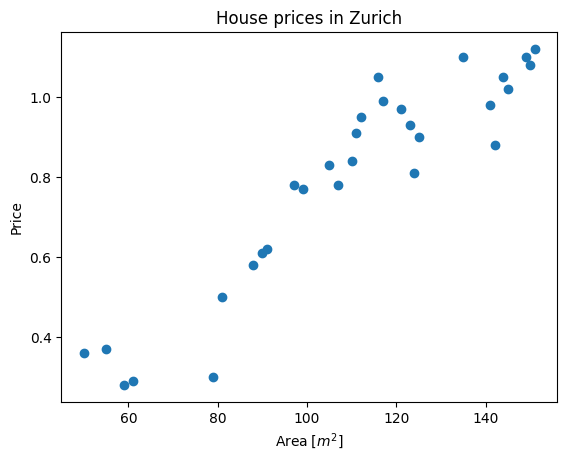

In [14]:
plt.scatter(x1,y)
plt.ylabel("Price")
plt.xlabel(r'$\text{Area}\; [m^2]$')
plt.title("House prices in Zurich")

### Plot Functions

In [15]:
def plot_with_uncertainty(Xp, mu, Sigma, color='r', color_samples='b', title="", num_samples=0):
    
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma))

    
    # plot distribution
    plt.plot(Xp, mean, color=color, label='Mean')
    plt.plot(Xp, mean + 1.96*std, color=color, linestyle='--')
    plt.plot(Xp, mean - 1.96*std, color=color, linestyle='--')
    plt.fill_between(Xp.ravel(), mean - 1.96*std, mean + 1.96*std, color=color, alpha=0.25, label='Confidence')
    plt.title(title)
    
def plot_data():
    plt.plot(x1, y, 'k.', markersize=5, label='Data')
    plt.xlabel(r'$\text{Area}\; [m^2]$')
    plt.ylabel('Price')
    plt.ylim((-2.4, 2.4))

### Conditioning on two observations without noise

In [16]:
x_star = np.linspace(40,160,100)

In [17]:
sigma2 = 0.
alpha = 1
scale = 10

Xp = x_star.reshape(-1,1)
X_tr = x1[[0,15]].reshape(-1,1)
y_tr = y[[0,15]]

print(f"P = {Xp.shape[0]}")
print(f"D = {Xp.shape[1]}")
print(f"N = {X_tr.shape[0]}")
print(f"D ={X_tr.shape[1]}")
# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, X_tr, y_tr, scale, alpha, sigma2)
print(f"Shape of mu_post is {mu_post.shape}")
print(f"Shape of Sigma_post is {Sigma_post.shape}")

P = 100
D = 1
N = 2
D =1
Shape of mu_post is (100,)
Shape of Sigma_post is (100, 100)


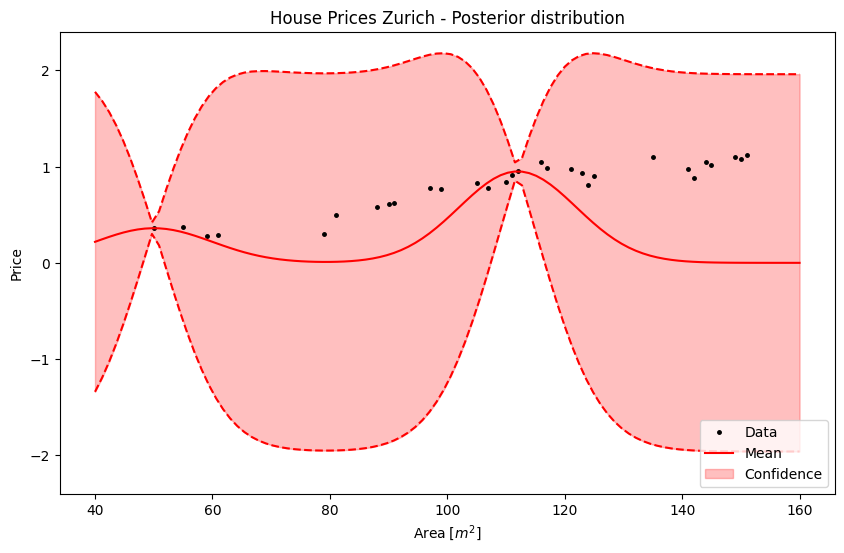

In [18]:
plt.figure(figsize=(10, 6))
plot_data()
plot_with_uncertainty(Xp, mu_post, Sigma_post, title='House Prices Zurich - Posterior distribution')
plt.legend(loc='lower right')

### Conditioning on 5 observations without noise

In [19]:
sigma2 = 0.
alpha = 1
scale = 10

Xp = x_star.reshape(-1,1)
X_tr = x1[[3,5,15,24,29]].reshape(-1,1)
y_tr = y[[3,5,15,24,29]]

print(f"P = {Xp.shape[0]}")
print(f"D = {Xp.shape[1]}")
print(f"N = {X_tr.shape[0]}")
print(f"D ={X_tr.shape[1]}")
# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, X_tr, y_tr, scale, alpha, sigma2)
print(f"Shape of mu_post is {mu_post.shape}")
print(f"Shape of Sigma_post is {Sigma_post.shape}")

P = 100
D = 1
N = 5
D =1
Shape of mu_post is (100,)
Shape of Sigma_post is (100, 100)


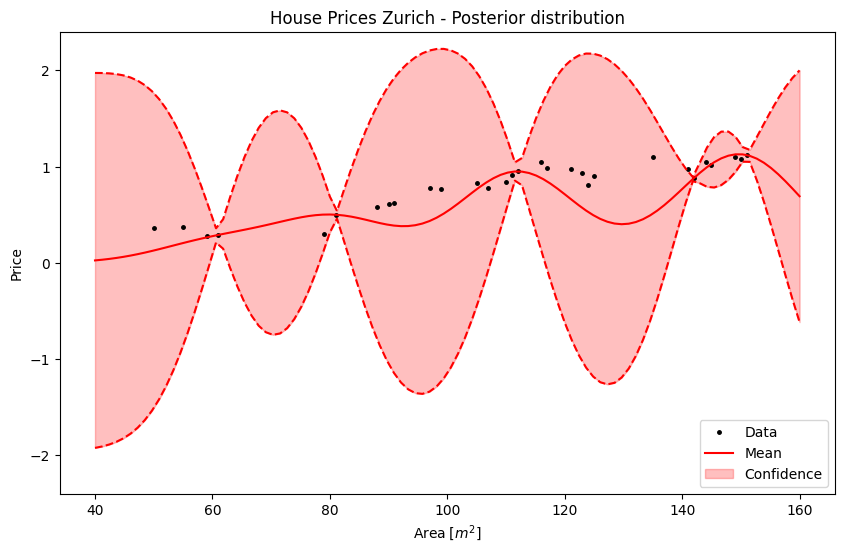

In [20]:
plt.figure(figsize=(10, 6))
plot_data()
plot_with_uncertainty(Xp, mu_post, Sigma_post, title='House Prices Zurich - Posterior distribution')
plt.legend(loc='lower right')
plt.savefig("house_prices_cond_5obs.png", dpi=300, bbox_inches='tight')  # Optional parameters: dpi and bbox_inches

### Conditioning on all points with measurement noise

In [21]:
sigma2 = 0.00218
alpha = 1
scale = 10

Xp = x_star.reshape(-1,1)
X_tr = x1.reshape(-1,1)
y_tr = y

print(f"P = {Xp.shape[0]}")
print(f"D = {Xp.shape[1]}")
print(f"N = {X_tr.shape[0]}")
print(f"D ={X_tr.shape[1]}")
# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, X_tr, y_tr, scale, alpha, sigma2)
print(f"Shape of mu_post is {mu_post.shape}")
print(f"Shape of Sigma_post is {Sigma_post.shape}")

P = 100
D = 1
N = 30
D =1
Shape of mu_post is (100,)
Shape of Sigma_post is (100, 100)


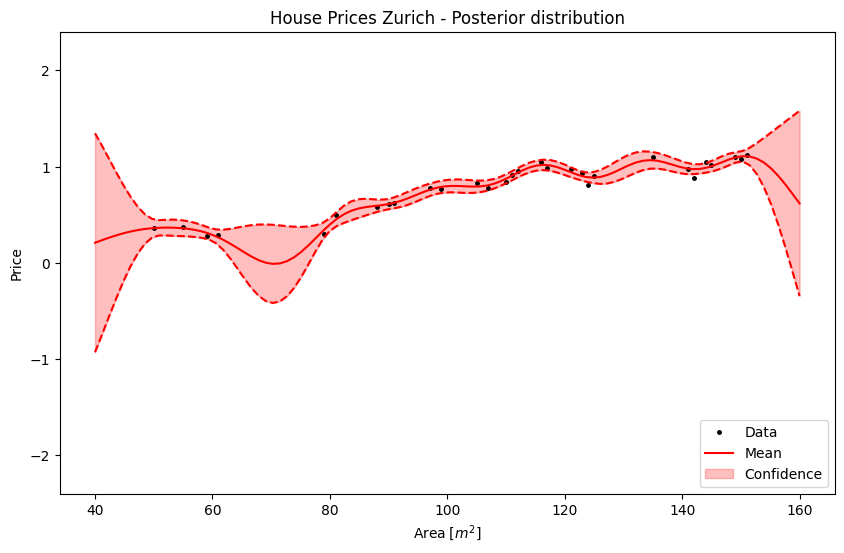

In [22]:
plt.figure(figsize=(10, 6))
plot_data()
plot_with_uncertainty(Xp, mu_post, Sigma_post, title='House Prices Zurich - Posterior distribution')
plt.legend(loc='lower right')

### Gaussian Processes with scikit-learn

In [23]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [24]:
kernel = RBF(1.0) + WhiteKernel(noise_level=1.0)
# kernel = RBF(1.0)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(np.array(x1).reshape(-1, 1), y)

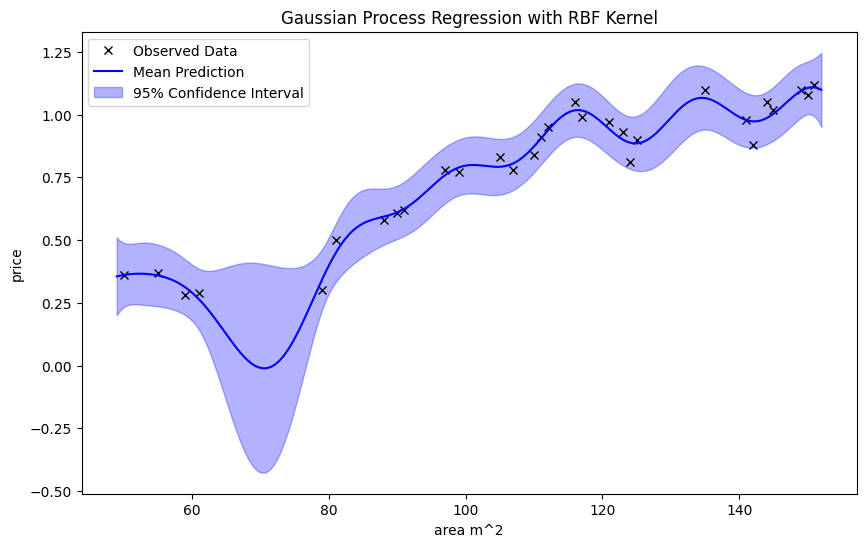

In [25]:
# Generate test points for prediction
X_test = np.linspace(x1.min() - 1, x1.max() + 1, 1000).reshape(-1, 1)

# Get the mean prediction and standard deviation (uncertainty)
y_mean, y_std = gpr.predict(X_test, return_std=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x1, y, 'kx', label="Observed Data")  # Original data points
plt.plot(X_test, y_mean, 'b-', label="Mean Prediction")  # Mean prediction line
plt.fill_between(X_test.ravel(),  # Confidence interval as shaded area
                 y_mean - 1.96 * y_std, 
                 y_mean + 1.96 * y_std, 
                 alpha=0.3, color='blue', label="95% Confidence Interval")

# Labels and legend
plt.xlabel("area m^2")
plt.ylabel("price")
plt.title("Gaussian Process Regression with RBF Kernel")
plt.legend()
plt.show()

#### R^2 Metric

In [26]:
gpr.score(np.array(x1).reshape(-1, 1), y)

0.9827990109592669

In [27]:
# Print the optimized kernel and hyperparameters
print("Optimized Kernel:", gpr.kernel_)
print("Hyperparameters:", gpr.kernel_.get_params())

Optimized Kernel: RBF(length_scale=10) + WhiteKernel(noise_level=0.00218)
Hyperparameters: {'k1': RBF(length_scale=10), 'k2': WhiteKernel(noise_level=0.00218), 'k1__length_scale': 10.00153528818161, 'k1__length_scale_bounds': (1e-05, 100000.0), 'k2__noise_level': 0.002183784875513143, 'k2__noise_level_bounds': (1e-05, 100000.0)}
